# Free energies and mutual info priors

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tramp.experiments import qplot

## Compare empirical/marchenko

In [2]:
#%run linear_free_energies.py
compare =  pd.read_csv("linear_free_energies.csv")

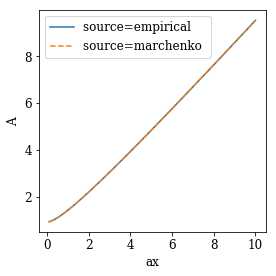

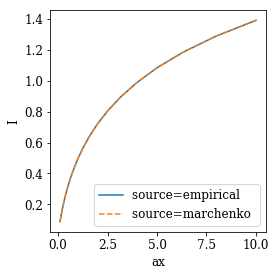

In [3]:
qplot(compare.query("az==1"), x="ax", y="A", linestyle="source")
qplot(compare.query("az==1"), x="ax", y="I", linestyle="source")

## Map : to improve

In [4]:
df = compare.query("source=='marchenko'")
pivoted = {
    col: pd.pivot(df, index="ax",columns="az",values=col) 
    for col in df.columns
}

In [5]:
def plot_2d_field(x,y,z,ux,uy):
    X = np.log10(pivoted[x])
    Y = np.log10(pivoted[y])
    Z = pivoted[z]
    U = pivoted[ux]
    V = pivoted[uy]
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    ax.contourf(X, Y, Z)
    #ax.contour(X, Y, Z)
    #ax.contour(cs, colors='k')
    ax.quiver(X, Y, U, V, color="white")
    ax.set(title=z,xlabel=f"log10 {x}",ylabel=f"log10 {y}");

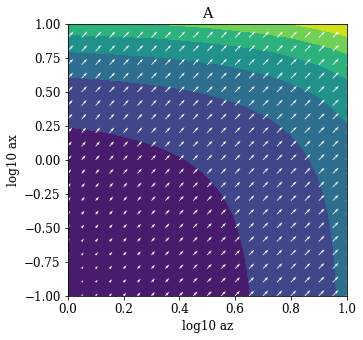

In [6]:
plot_2d_field("az","ax","A","mz","mx")

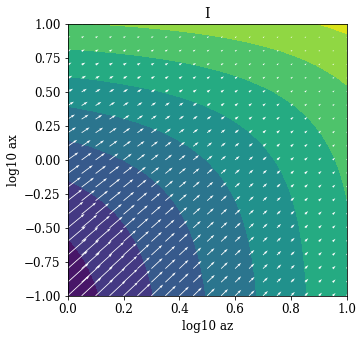

In [7]:
plot_2d_field("az","ax","I","vz","vx")

## Check gradient

In [8]:
wrt_ax = pd.read_csv("linear_free_energies_wrt_ax.csv").query("source=='marchenko'")
wrt_az = pd.read_csv("linear_free_energies_wrt_az.csv").query("source=='marchenko'")

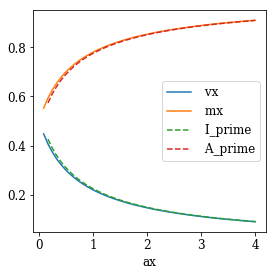

In [9]:
def check_gradient_ax(subset):
    check = wrt_ax.query(subset).sort_values(by="ax")
    check["I_prime"] = 2 * check["I"].diff() / (check["alpha"]*check["ax"].diff())
    check["A_prime"] = 2 * check["A"].diff() / (check["alpha"]*check["ax"].diff())
    qplot(
        check, x="ax", y=["vx", "mx", "I_prime", "A_prime"], 
        y_markers=["-", "-", "--", "--"], y_legend=True
    )
check_gradient_ax("az==2")

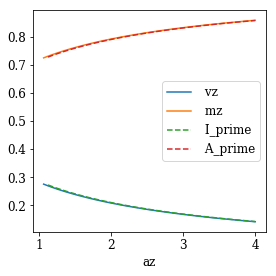

In [10]:
def check_gradient_az(subset):
    check = wrt_az.query(subset).sort_values(by="az")
    check["I_prime"] = 2 * check["I"].diff() / check["az"].diff()
    check["A_prime"] = 2 * check["A"].diff() / check["az"].diff()
    qplot(
        check, x="az", y=["vz", "mz", "I_prime", "A_prime"], 
        y_markers=["-", "-", "--", "--"], y_legend=True
    )
check_gradient_az("ax==2")

## Check reverse mapping

Careful: actually $m_x$ depends on $m_z$, so to compute the partial derivative from the
discrete derivative we have to add a counter-term:
$$
\frac{d}{dm_z} A^* = \partial_{m_z} A^* + \frac{dm_x}{dm_z} \partial_{m_x} A^* = \frac{a_z}{2} + \frac{dm_x}{dm_z} \frac{\alpha a_x}{2} \\
\frac{a_z}{2} = \frac{d}{dm_z} A^* - \frac{dm_x}{dm_z} \frac{\alpha a_x}{2}
$$

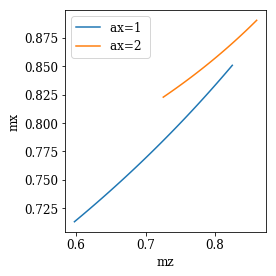

In [11]:
# m_x depends on m_z in our experiments
qplot(wrt_az, x="mz", y="mx", color="ax")

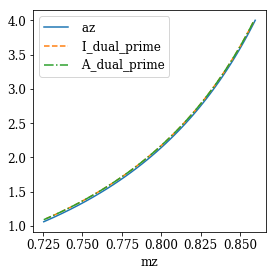

In [12]:
def check_reverse_vz(subset):
    check = wrt_az.query(subset).sort_values(by="vz")
    
    I_dual_prime = check["I_dual"].diff() / check["vz"].diff()
    v_prime = check["vx"].diff() / check["vz"].diff()
    I_counter_term = 0.5*check["alpha"]*check["ax"]*v_prime
    check["I_dual_prime"] = (-2) * (I_dual_prime + I_counter_term)
    
    A_dual_prime = check["A_dual"].diff() / check["mz"].diff()
    m_prime = check["mx"].diff() / check["mz"].diff()
    A_counter_term = -0.5*check["alpha"]*check["ax"]*m_prime
    check["A_dual_prime"] = (2) * (A_dual_prime + A_counter_term)
    
    qplot(
        check, x="mz", y=["az", "I_dual_prime", "A_dual_prime"], 
        y_markers=["-", "--", "-."], y_legend=True
    )
check_reverse_vz("ax==2")

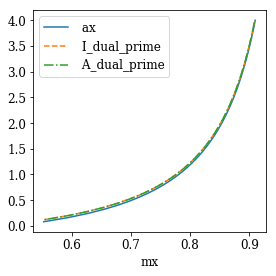

In [13]:
def check_reverse_vx(subset):
    check = wrt_ax.query(subset).sort_values(by="vx")
    
    I_dual_prime = check["I_dual"].diff() / check["vx"].diff()
    v_prime = check["vz"].diff() / check["vx"].diff()
    I_counter_term = 0.5*check["az"]*v_prime
    check["I_dual_prime"] = (-2 / check["alpha"]) * (I_dual_prime + I_counter_term)
    
    A_dual_prime = check["A_dual"].diff() / check["mx"].diff()
    m_prime = check["mz"].diff() / check["mx"].diff()
    A_counter_term = -0.5*check["az"]*m_prime
    check["A_dual_prime"] = (2 / check["alpha"]) * (A_dual_prime + A_counter_term)
    
    qplot(
        check, x="mx", y=["ax", "I_dual_prime", "A_dual_prime"], 
        y_markers=["-", "--", "-."], y_legend=True
    )
check_reverse_vx("az==2")